# Install needed packages

In [1]:
# Needed Packages to comunicate with mySQL from python
!pip install sqlalchemy mysql-connector-python

!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install ydata_profiling
!pip install ipywidgets

# Load Libraries

In [2]:
from sqlalchemy import create_engine, text
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Connect to the Database

In [3]:
# Connect to MySQL
connection_string = 'mysql+mysqlconnector://root:pw@172.17.0.1:3306/titanic'

In [4]:
engine = create_engine(connection_string)
conn = engine.connect()

## Test Connection

In [5]:
query = text("SELECT salutation, first_name, last_name FROM passengers WHERE survived = false;")
result = conn.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the results
print(df)

    salutation                         first_name     last_name
0         Miss                      Helen Loraine       Allison
1           Mr            Hudson Joshua Creighton       Allison
2          Mrs  Hudson J C (Bessie Waldo Daniels)       Allison
3           Mr                          Thomas Jr       Andrews
4           Mr                              Ramon  Artagaveytia
..         ...                                ...           ...
792       Miss                             Hileni        Zabour
793       Miss                            Thamine        Zabour
794         Mr                        Mapriededer      Zakarian
795         Mr                              Ortin      Zakarian
796         Mr                                Leo     Zimmerman

[797 rows x 3 columns]


# Fetch all the data to pandas

In [6]:
query = text("SELECT * FROM passengers;")
result = conn.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Analyze the dataset distribution aimed towards the survived target class

## Bin by age and see survived distribution

          Survived percentage
age_bin                      
(0, 10]             58.139535
(10, 20]            39.490446
(20, 30]            36.676218
(30, 40]            42.307692
(40, 50]            39.230769
(50, 60]            49.180328
(60, 70]            22.222222
(70, 80]            33.333333


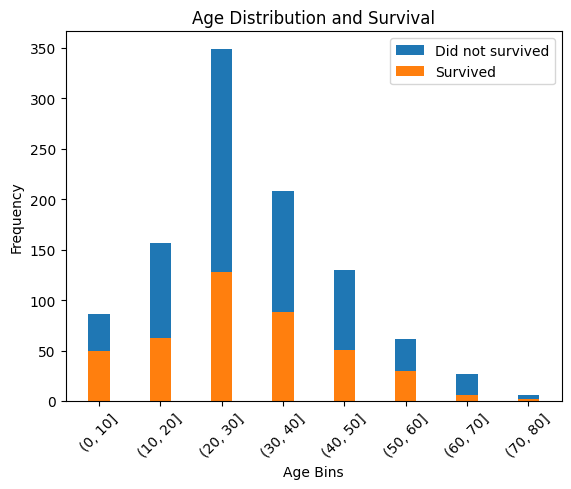

In [7]:
# Create bins
min_age = df['age'].min()
max_age = df['age'].max()
bins = range(int(min_age // 10 * 10), int((max_age // 10 + 1) * 10), 10)

# Cut the 'age' column into bins
df['age_bin'] = pd.cut(df['age'], bins=bins)

# Count the frequency of each bin for both 'age' and 'survived'
age_counts = df['age_bin'].value_counts().sort_index()
survived_counts = df.groupby('age_bin', observed=False)['survived'].sum()

# Calculate percentage of survivors per age bin
survival_percentages_age = (survived_counts / age_counts) * 100

# Plot the results
bar_width = 0.35
fig, ax = plt.subplots()
age_bar = ax.bar(age_counts.index.astype(str), age_counts.values, bar_width, label='Did not survived')
survived_bar = ax.bar(age_counts.index.astype(str), survived_counts, bar_width, label='Survived')

ax.set_xlabel('Age Bins')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution and Survival')
ax.legend()

plt.xticks(rotation=45)
plt.show

# Create a DataFrame for the table
table_data = pd.DataFrame({'Survived percentage': survival_percentages_age})

print(table_data)

## See ticket class and survived distribution

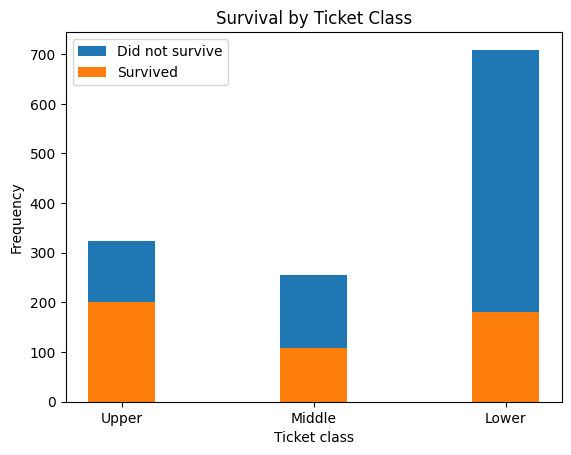

        Survived percentage
pclass                     
1                 61.919505
2                 42.745098
3                 25.528914


In [8]:
# Count the frequency of each category for both 'embarked' and 'survived'
pclass_counts = df['pclass'].value_counts().sort_index()
survived_counts = df.groupby('pclass')['survived'].sum()

# Calculate percentage of survivors
survival_percentages_class = (survived_counts / pclass_counts) * 100

# Plot the results
bar_width = 0.35
fig, ax = plt.subplots()
embarked_bar = ax.bar(pclass_counts.index, pclass_counts, bar_width, label='Did not survive')
survived_bar = ax.bar(pclass_counts.index, survived_counts, bar_width, label='Survived')

ax.set_xlabel('Ticket class')
ax.set_ylabel('Frequency')
ax.set_title('Survival by Ticket Class')
ax.legend()

# Add labels for each class
labels = {1: 'Upper', 2: 'Middle', 3: 'Lower'}
ax.set_xticks(pclass_counts.index)
ax.set_xticklabels([labels[x] for x in pclass_counts.index])

plt.show()

# Create a DataFrame for the table
table_data = pd.DataFrame({'Survived percentage': survival_percentages_class})
print(table_data)


## See sex and survived distribution

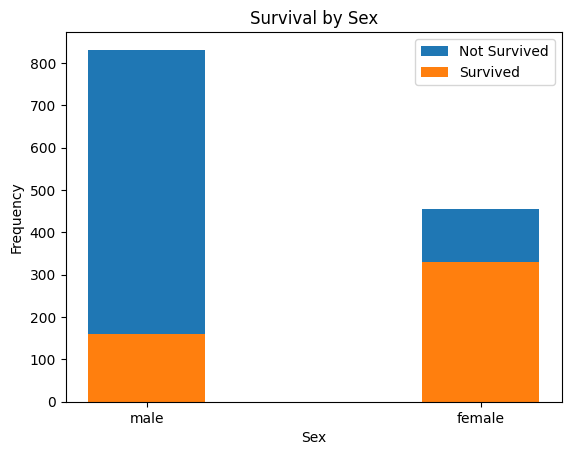

        Survived percentage
sex                        
female            72.149123
male              19.374248


In [9]:
# Count the frequency of each category for both 'sex' and 'survived'
sex_counts = df['sex'].value_counts()
survived_counts_by_sex = df.groupby('sex')['survived'].sum()

# Calculate percentage of survivors
survival_percentages_sex = (survived_counts_by_sex / sex_counts) * 100

# Plot the results
fig, ax = plt.subplots()
bar_width = 0.35
sex_bar = ax.bar(sex_counts.index, sex_counts, bar_width, label='Not Survived')
survived_bar = ax.bar(survived_counts_by_sex.index, survived_counts_by_sex, bar_width, label='Survived')

ax.set_xlabel('Sex')
ax.set_ylabel('Frequency')
ax.set_title('Survival by Sex')
ax.legend()

plt.show()

# Create a DataFrame for the table
table_data = pd.DataFrame({'Survived percentage': survival_percentages_sex})
print(table_data)

## See fare and survived distribution

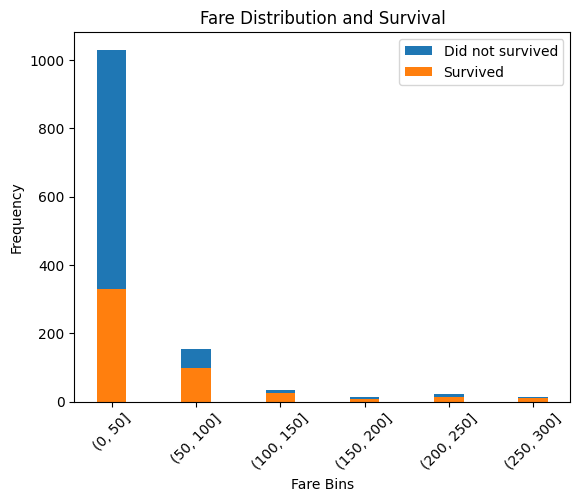

            Survived percentage
fare_bin                       
(0, 50]               32.038835
(50, 100]             63.225806
(100, 150]            78.787879
(150, 200]            61.538462
(200, 250]            57.142857
(250, 300]            76.923077


In [10]:
# Create bins for fare
min_fare = df['fare'].min()
max_fare = df['fare'].max()
bins = np.arange(int(min_fare // 50) * 50, int((max_fare // 50 + 1) * 50), 50)

# Cut the 'fare' column into bins
df['fare_bin'] = pd.cut(df['fare'], bins=bins)


# Count the frequency of each bin for both 'fare' and 'survived'
fare_counts = df['fare_bin'].value_counts().sort_index()
survived_counts = df.groupby('fare_bin', observed=False)['survived'].sum()

# Remove bins with no data
fare_counts = fare_counts[fare_counts > 0]
survived_counts = survived_counts[fare_counts.index]  # Update survived counts accordingly

# Calculate percentage of survivors per fare bin
survival_percentages_fare = (survived_counts / fare_counts) * 100

# Plot the results
bar_width = 0.35
fig, ax = plt.subplots()
fare_bar = ax.bar(fare_counts.index.astype(str), fare_counts.values, bar_width, label='Did not survived')
survived_bar = ax.bar(fare_counts.index.astype(str), survived_counts, bar_width, label='Survived')

ax.set_xlabel('Fare Bins')
ax.set_ylabel('Frequency')
ax.set_title('Fare Distribution and Survival')
ax.legend()

plt.xticks(rotation=45)
plt.show()

# Create a DataFrame for the table
table_data = pd.DataFrame({'Survived percentage': survival_percentages_fare})
print(table_data)


# Correlation Heatmap
A correlation heatmap is a visual representation of the correlation between variables in a dataset. It uses colors to show the strength and direction of these relationships.

## How to read
- Color Gradient: Colors indicate correlation strength, with red for positive correlation and blue for negative correlation.
- Diagonal Line: Represents perfect correlation (1) of variables with themselves.
- Symmetry: The heatmap is symmetrical around the diagonal.

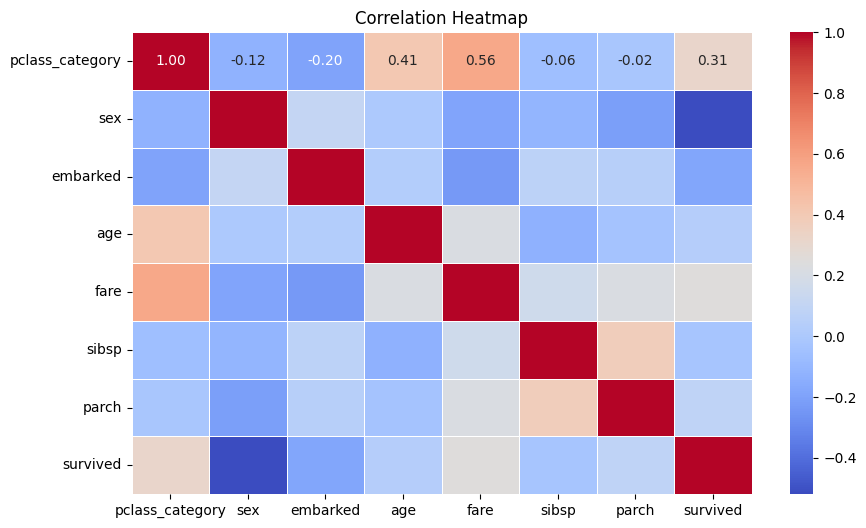

In [11]:
# Categorize 'pclass'
pclass_mapping = {1: 'Upper', 2: 'Middle', 3: 'Lower'}
df['pclass_category'] = df['pclass'].map(pclass_mapping)

# Calculate correlation coefficients for categorical parameters
categorical_params = ['pclass_category', 'sex', 'embarked']
correlation_data = pd.DataFrame(columns=categorical_params)
for param in categorical_params:
    if df[param].dtype == 'O':  # If parameter is categorical
        df[param + '_encoded'] = pd.Categorical(df[param]).codes
        correlation_data[param] = df[param + '_encoded']

# Add 'age', 'fare', 'sibsp', 'parch', and 'survived' to correlation data
correlation_data['age'] = df['age']
correlation_data['fare'] = df['fare']
correlation_data['sibsp'] = df['sibsp']
correlation_data['parch'] = df['parch']
correlation_data['survived'] = df['survived']

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Generate general report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

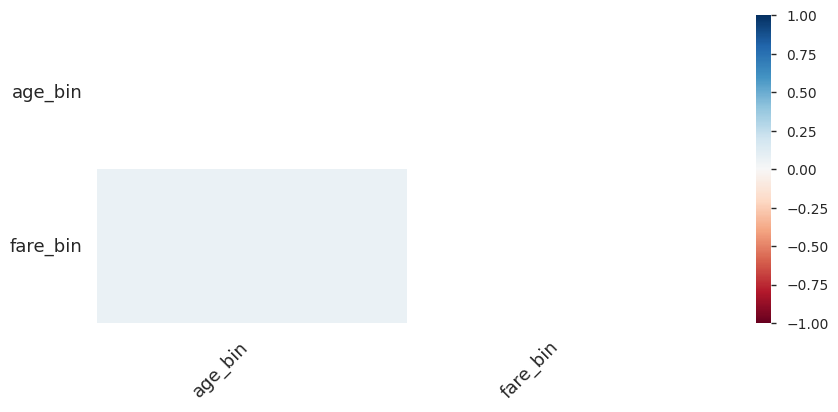

In [12]:
profile = ProfileReport(df, title="Profiling Report")

profile.to_notebook_iframe()

# Multivariable logistic Regression
A multivariable logistic regression with a binary target variable aims to predict a binary outcome based on multiple predictor variables.

- Objective: The goal is to predict the probability of a binary outcome (e.g., Yes/No, 0/1) based on the values of multiple predictor variables.
- Model: It uses a regression model (e.g., logistic regression) to estimate the relationship between the predictors and the probability of the binary outcome.
- Prediction: Given values for the predictor variables, the model calculates the predicted probability of the binary outcome. This probability can then be converted into a binary decision based on a chosen threshold.

## Interpretation of regressions metrics
- Accuracy
    - The accuracy score measures the proportion of correct predictions made by the model out of the total number of predictions.
    - It is calculated as the number of correct predictions divided by the total number of predictions.
- Confusion Matrix
    - A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.
    - It's a matrix with four different combinations of predicted and actual classes: True Positive (TP), False Positive (FP), True Negative (TN), and False Negative (FN).
    - It provides a more detailed breakdown of the model's performance than just the accuracy score.
- Classification Report
    - Precision: Out of all predicted positive instances, how many were actually positive.
    - Recall (Sensitivity): Out of all actual positive instances, how many were predicted correctly.
    - F1-score: Harmonic mean of precision and recall. It gives a balance between precision and recall.
    - Support: Number of actual occurrences of the class in the dataset.

## ROC Curve (Receiver Operating Characteristic Curve)
The ROC curve is a graphical representation of the performance of a binary classification model across different thresholds. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity) for various threshold values. Each point on the curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

### Interpretation of ROC Area (AUC):
The Area Under the ROC Curve (AUC) quantifies the overall performance of a binary classification model. It ranges from 0 to 1, where:

- AUC = 1 indicates a perfect classifier that perfectly separates the classes.
- AUC = 0.5 indicates a classifier that performs no better than random guessing.
- AUC < 0.5 indicates a classifier that performs worse than random guessing (inverted predictions).

Typically, an AUC above 0.7 is considered acceptable, while an AUC above 0.8 is considered good discrimination.

Accuracy: 0.7441860465116279
Confusion Matrix:
 [[121  26]
 [ 40  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.79       147
           1       0.73      0.64      0.68       111

    accuracy                           0.74       258
   macro avg       0.74      0.73      0.73       258
weighted avg       0.74      0.74      0.74       258



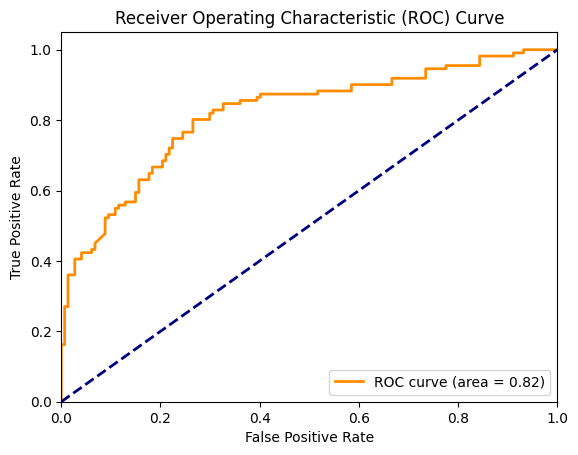

In [13]:
# Select independent variables (X) and dependent variable (y)
independent_variables = df[['age', 'fare', 'pclass', 'sex']]
dependent_variable = df['survived']

# Perform one-hot encoding for the 'sex' column
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), ['sex'])], 
    remainder='passthrough'
)
independent_variables_encoded = column_transformer.fit_transform(independent_variables)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(independent_variables_encoded, dependent_variable, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
